#### References
- http://jalammar.github.io/illustrated-transformer/
- http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder-and-decoder-stacks
- https://github.com/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb
- https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import os
import time
import numpy as np
import copy

SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [2]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(sequential=True,tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

### `<sos>` 와 `<eos>` 에 대한 논의
- 아시는 분도 계시겠지만, 각각 Start Of Sentence, End of Sentence 를 의미합니다.
- Encoder와 Decoder 에 들어가는 source data, target data에 대해 앞뒤로 해당 두 토큰이 들어가게 됩니다.
- 문장의 시작과 끝을 일괄적으로 적용시켜줌으로써, 문장의 시작점과 끝점을 알려주는 역할을 합니다.
- CNN에서 이미지 처리를 할 때, 모서리 부분에 padding을 적용해줌으로써, 이미지의 경계를 학습시키는 효과와 유사합니다.

In [3]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))
# 영어와, 독일 데이터를 다운받으면서, train, validation, test 데이터로 나눠서 가져오게 됩니다.

In [4]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
# 최소한 2번 이상 나오는 vocab에 대해서만, numericalize 시키게 됩니다.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
BATCH_SIZE = 50

train_iter, test_iter = BucketIterator.splits\
    (
    (train_data, test_data), batch_size=BATCH_SIZE, device=device
    )

# device 는 cpu 또는 gpu 를 적용하게 되고, (pytorch에서는 Variable(device=device) 와 같은 형태로, 
#인풋 데이터에 대해서 device 를 할당해줍니다.
# batch_size 를 할당해주면, 반환값에 randomly batch가 적용됩니다.(1000개씩 묶인 상태에서, 인덱스가 랜덤으로 섞인 iterator 가 됩니다.)

In [7]:
batch = next(iter(train_iter))
batch.src.size()

torch.Size([25, 50])

## Hyperparameters

In [8]:
d_model = 512
d_q,d_k,d_v = 512//8,512//8,512//8
heads = 8
d_ff = 128
enc_vocab_size = len(SRC.vocab.stoi)
dec_vocab_size = len(TRG.vocab.stoi)

src_word_to_idx = SRC.vocab.stoi
src_idx_to_word = {val:idx for idx,val in src_word_to_idx.items()}

trg_word_to_idx = TRG.vocab.stoi
trg_idx_to_word = {val:idx for idx,val in trg_word_to_idx.items()}

### transformer architecture
- input Embedding + Positional Encoding
- Multi-Head Attention
- Residual Connection + Layer Normalization
- Position-Wise Feed Forward Networks
- Residual Connection + Layer Normalization

In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2.0) *
                             -(math.log(10000.0) / d_model))
        
        """
        div_term : 
                    1               
                ----------        ==    e^{2i * -log(10000)/d_model}   
            10000^{2i/d_model}          
        """
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)].to(device), 
                         requires_grad=False)
        return self.dropout(x)

In [10]:
PE = PositionalEncoding(d_model,0.1)

In [11]:
def get_attn_key_pad_mask(q,k):
    """
    pad token이 있는 곳에 1을 부여 합니다. 이는 후에, 마스킹이 되어 
    self-attention이 적용되지 않는 부분을 인식시켜 주는 역할을 하게 됩니다.
    k : [batch_size, len_k] // encoder, decoder의 input sequence (NOT embedding)
    q : [batch_size, len_q] // encoder, decoder의 input sequence (NOT embedding)
    """
    batch_size, len_q = q.size()
    batch_size, len_k = k.size()
    
    padding_mask = k.eq(SRC.vocab.stoi['<pad>']) 
    # k에 pad token에만 1을 부여합니다. [batch_size, len_k]
    padding_mask = padding_mask.unsqueeze(1).expand(batch_size, len_q, len_k)  
    # [batch_size, len_q,len_k]

    return padding_mask

In [12]:
get_attn_key_pad_mask(batch.src.permute(1,0),batch.src.permute(1,0)).size()

torch.Size([50, 25, 25])

In [13]:
def get_subsequent_mask(dec_inputs):
    """
    정방삼각행렬을 만들어서, 상방을 1로 만들어 주면서, 다음 위치에 있는 것들에 
    self-attention이 적용되지 않게 하는 역할을 합니다.
    """
    batch_size, dec_seq = dec_inputs.size()
    subsequent_mask = torch.triu(
        torch.ones((dec_seq,dec_seq), device='cpu', dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(batch_size, -1, -1) 

    return subsequent_mask

In [14]:
get_subsequent_mask(batch.trg.permute(1,0)).size()

torch.Size([50, 24, 24])

## ScaledDotProductAttention
_______________________
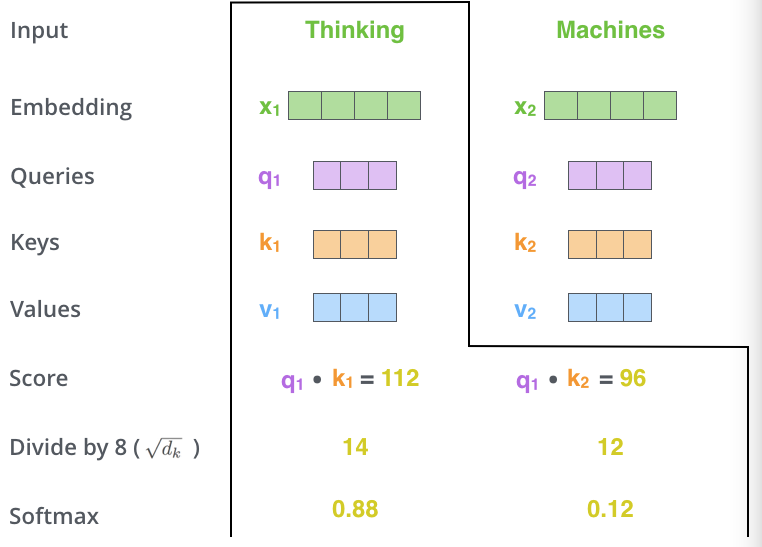

In [15]:
class ScaledDotProductAttention(nn.Module) : 
    """
    init으로 받는 arguments는 없습니다.
    query,key,value를 받아서,  
    scaled_attn = sortmax(dot_product(Q,K)/sqrt(d_v))
    output = scaled_attn * V
    의 연산을 진행, 반환해줍니다.
    """
    def __init__(self) : 
        super(ScaledDotProductAttention,self).__init__() 
        
    def forward(self,q,k,v,attn_mask) : 
        """
        Q,K,V : multi-head self attention 클래스에서 q,k,v로 나뉘어진 후, 
        multi-head 갯수만큼 나온 행렬 값들입니다.
        [batch_size,len_{Q,K,V},heads,d_model]
        attn_mask : get_attn_key_pad_mask 함수와 get_subsequent_mask의 합의 형태로,
        masking을 취해주어야 할 부분에 1이 채워져 있는 행렬입니다.
        """
        d_v = v.size(-1)
        
        energy = torch.matmul(q, k.transpose(-1,-2)) / np.sqrt(d_v)
        #[batch_size, heads, len_q, len_k]
        energy.masked_fill_(attn_mask,-np.inf) 
        # attn_mask 에 1인 부분을 -극한으로 취해줍니다.
        attn = torch.softmax(energy,dim=-1)
        ##[batch_size, heads, len_q, len_k]      
        output = torch.matmul(attn,v)
        ##[batch_size, heads, len_q, d_model/heads]
        
        return output, attn

### MultiHeadAttention
_______________
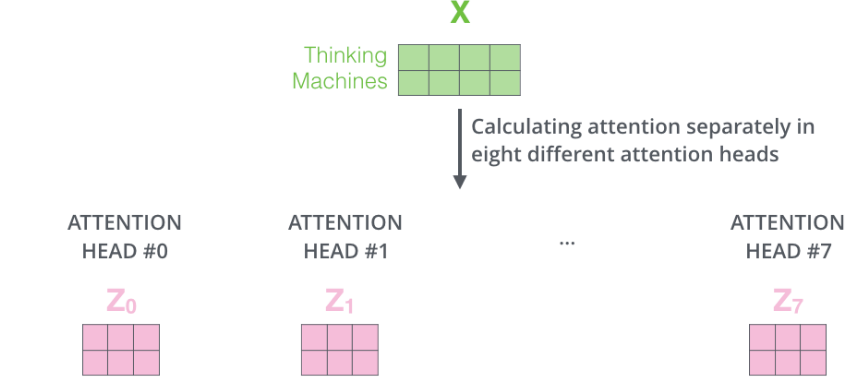

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self) : 
        super(MultiHeadAttention,self).__init__() 
        """
        {q,k,v}_weight : 임베딩된 input에 각기 다른 weight matrix를 곱해 query, key, value를 
        생성해주어야 합니다. 멀티 헤드로 진행되어야 하므로(h=8) 8개의 weight matrix가 있어야 합니다.
        nn.Linear 에는 in_features와 out_features를 명시할 수 있으므로, [d_model,d_q,head]를
        [d_model,d_q*head]와 같이 써준 후, 뒤에서 차원을 분리시켜줍니다.
        """        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.q_weight = nn.Linear(d_model,d_q*heads).to(device)
        self.k_weight = nn.Linear(d_model,d_k*heads).to(device)
        self.v_weight = nn.Linear(d_model,d_v*heads).to(device)
        self.projection = nn.Linear(d_model,d_model).to(device)

    def forward(self,q,k,v,attn_mask) : 
        """
        q,k,v는 각기 다른 것 같지만, 위의 init 에서 설정된 weight matrix를 거치기 전까지는 모두 
        같은 input data의 embedding 결과값입니다.(decoder의 encoder-decoder attention의 경우는
        이전의 decoder self-attention의 output값이 됩니다. 하지만, 결과적으로는 모두 같은 차원인
        [batch_size, sequence_length, d_model]을 따릅니다.

        residual connection과 layer normalization이 이뤄집니다. residual connection에서 
        residual은 q과 k를 attention 을 적용할 때, 기준이 되는 토큰을 의미하는 것은 query이기 때문에,
        q가 input이 되고, 이에 따라 residual도 query가 됩니다.
        """

        residual = q; batch_size = q.size(0);d_model = q.size(-1)
        d_splitted = d_model // heads
        
        q_heads = self.q_weight(q).view(batch_size,heads,-1,d_splitted)
        k_heads = self.k_weight(k).view(batch_size,heads,-1,d_splitted)
        v_heads = self.v_weight(v).view(batch_size,heads,-1,d_splitted)
        #{q,k,v}_heads : [batch_size, heads, seq_length, d_model/heads]
        
        attn_mask = attn_mask.unsqueeze(1).repeat(1,heads,1,1)
        # attn_mask : [batch_size x n_heads x len_q x len_k]
        output, attn = ScaledDotProductAttention()(q_heads, k_heads, v_heads, attn_mask)
        # output : [batch_size, heads, len_q, d_model/heads]
        # 위의 output을 다시 d_model의 차원으로 바꿔주어야 하기 때문에, 
        # head의 갯수만큼 있는 attention Z 행렬을 concat하고 linear projection시켜줍니다.            
        output = output.permute(0,2,1,3).contiguous().view(batch_size,-1,d_model)
        # [batch_size, seq_length, d_model]
        output = self.projection(output)# [batch_size, seq_length, d_model]

        return nn.LayerNorm(d_model).to(device)(output+residual), attn

### PoswiseFeedForwardNet
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

- **convolution(kernel=1) + ReLU + convolution(kernel=1)**
- 원문 인용 : While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as `two convolutions with kernel size 1.` The dimensionality of input and output is $d_{model}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [17]:
class PoswiseFeedForwardNet(nn.Module) : 
    
    def __init__(self) : 
        super(PoswiseFeedForwardNet,self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.convs1 = nn.Conv1d(in_channels=d_model,out_channels=d_ff,kernel_size=1).to(self.device)
        self.convs2 = nn.Conv1d(in_channels=d_ff,out_channels=d_model,kernel_size=1).to(self.device)
        
    def forward(self,inputs) : 
        """
        inputs : multi-head self-attention에서 반환된 output을 의미합니다.
        [batch_size, sequence_length, d_model]
        """
        residual = inputs.clone() #[batch_size, sequence_length, d_model]
        output = nn.ReLU()(self.convs1(inputs.permute(0,2,1)))
        # output : [batch_size, d_ff, sequence_length]
        output = self.convs2(output).permute(0,2,1)
        # output : [batch_size, sequence_length, d_model]
        return nn.LayerNorm(d_model).to(self.device)(output + residual)
        # [batch_size, sequence_length, d_model]

In [18]:
poswiseFFN = PoswiseFeedForwardNet()

### EncoderLayer
- 인코더 하나의 레이어를 의미합니다. 하나의 레이어에는 두 개의 서브 레이어가 존재합니다. 이를 wrapping 하는 클래스입니다.
- MultiHeadAttention + PoswiseFeedForwardNet

In [19]:
class EncoderLayer(nn.Module) : 
    
    def __init__(self) : 
        super(EncoderLayer,self).__init__()
        self.multihead_attn = MultiHeadAttention()
        self.poswiseffn = PoswiseFeedForwardNet()
        
    def forward(self,enc_inputs,attn_mask) : 
        """
        enc_inputs : embedding representations
        attn_mask : encoder에서는 padding attn_mask, decoder에서는 padding + subsequence
        """
        enc_outputs,self_attn = self.multihead_attn(enc_inputs,enc_inputs,enc_inputs,attn_mask)
        enc_outputs = self.poswiseffn(enc_outputs)
        
        return enc_outputs, self_attn

In [20]:
enc_layer = EncoderLayer()

### DecoderLayer
- 디코더 하나의 레이어를 의미합니다. 하나의 레이어에는 세 개의 서브 레이어가 존재합니다. 이를 wrapping 하는 클래스입니다.
- MultiHeadAttention + MultiHeadAttention + PoswiseFeedForwardNet

In [21]:
class DecoderLayer(nn.Module) : 
    
    def __init__(self) : 
        super(DecoderLayer,self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.enc_dec_attn = MultiHeadAttention()
        self.poswiseffn = PoswiseFeedForwardNet()
    
    def forward(self,enc_inputs,dec_inputs,self_attn_mask,enc_dec_attn_mask) : 
        """
        decoder의 layer에는 3개의 sublayer가 존재하고, 각각 decoder self-attention, encoder-decoder attention, 
        position wise FFN 입니다. 두 개의 multi-head attention의 대상이 다르기 때문에, 다른 attention mask matrix가 
        적용됩니다. 또한, Q,K,V에서, encoder decoder attention의 경우, K,V가 encoder에서 오기 때문에, 이를 적용해주어야 합니다.
        """
        dec_outputs,self_attn = self.dec_self_attn(dec_inputs,dec_inputs,dec_inputs,self_attn_mask)
        dec_outputs,enc_dec_attn = self.dec_self_attn(dec_inputs,enc_inputs,enc_inputs,enc_dec_attn_mask)
        dec_outputs = self.poswiseffn(dec_outputs)
        
        return dec_outputs, self_attn, enc_dec_attn

## Encoder
- embedding + positional embedding 적용
- EncoderLayer의 stacking 적용
- padding index에 대해서 masking 적용

In [22]:
class Encoder(nn.Module) : 
    
    def __init__(self) : 
        super(Encoder,self).__init__() 
        self.init_embedding = nn.Embedding(enc_vocab_size,d_model).to(device)
        self.pos_embedding = PositionalEncoding(d_model,0.1).to(device)
        
        self.layers = nn.ModuleList([copy.deepcopy(EncoderLayer()) for _ in range(6)])
        
    def forward(self,enc_inputs) :
        enc_inputs = enc_inputs.permute(1,0) # [batch_size, sequence_length]
        embed = self.init_embedding(enc_inputs)
        enc_outputs = self.pos_embedding(embed) # [batch_size, sequence_length,d_model]
        
        enc_self_attn_record = []
        # identical layer가 6개 스택되는 동안, outputs은 계속해서 업데이트 됩니다.
        # self-attention 은 모델 내부에 필요한 요소는 아니지만, 후에 translation의 어탠션 구조를 
        # 볼 때, 용이하기 위해, 이를 저장하는 것입니다.(For explainable deep learning)
        for layer in self.layers :             
            enc_self_attn = get_attn_key_pad_mask(enc_inputs,enc_inputs)
        # encoder의 경우, padding 에 대해서만 masking 을 적용해주면 됩니다.            
            enc_outputs,enc_attn = layer(enc_outputs,enc_self_attn)
            enc_self_attn_record.append(enc_attn)

        return enc_outputs, enc_self_attn_record

In [23]:
enc = Encoder()

## Decoder
- embedding + positional embedding 적용
- DecoderLayer stacking 적용
- padding index와 subsequence에 대해서 masking 적용

In [24]:
class Decoder(nn.Module) : 
    
    def __init__(self) : 
        super(Decoder,self).__init__() 
        self.init_embedding = nn.Embedding(dec_vocab_size,d_model).to(device)
        self.pos_embedding = PositionalEncoding(d_model,0.1).to(device)
        
        self.layers = nn.ModuleList([copy.deepcopy(DecoderLayer()) for _ in range(6)])
        
    def forward(self,dec_inputs,enc_inputs,enc_outputs) :
        dec_inputs = dec_inputs.permute(1,0) # [batch_size, sequdece_length]
        enc_inputs = enc_inputs.permute(1,0)
        
        embed = self.init_embedding(dec_inputs)
        dec_outputs = self.pos_embedding(embed) # [batch_size, sequdece_length,d_model]
        
        self_dec_attn_pad_mask = get_attn_key_pad_mask(dec_inputs, dec_inputs).to(device)
        # dec_self_attn_pad_mask : padding 에 대해서 마스킹을 해준 것으로 
        # multi-head self-attention을 위함입니다.
        
        self_dec_attn_sub_mask = get_subsequent_mask(dec_inputs).to(device)
        # dec_self_attn_subsequent_mask : subsequence 에 대해서 마스킹을 해준 것으로 
        # multi-head self-attention을 위함입니다.
        
        self_dec_attn_mask = \
        torch.gt((self_dec_attn_pad_mask + self_dec_attn_sub_mask), 0)
        # 두 개의 합집합적 요소를 감안해, decoder의 auto-regressive 적 성향을 보존합니다.
        
        dec_enc_attn_mask = get_attn_key_pad_mask(dec_inputs, enc_inputs)
        # padding 에 대한 마스킹으로, encoder-decoder attention을 위함입니다.
        
        dec_self_attn_record = []
        enc_dec_attn_record = []
        
        for layer in self.layers :             
        # decoder 경우, padding과 subsequential에 대해서 masking 을 적용해주어야 합니다.            
            dec_outputs,dec_self_attn,enc_dec_attn = layer(\
                enc_outputs,dec_outputs, self_dec_attn_mask,dec_enc_attn_mask)
            dec_self_attn_record.append(dec_self_attn)
            enc_dec_attn_record.append(enc_dec_attn)
            
        return dec_outputs, dec_self_attn_record,enc_dec_attn_record

In [25]:
dec = Decoder()

## Transformer
- Encoder, Decoder를 wrapping 해주고, linear projection을 해주면 됩니다.

In [26]:
class Transformer(nn.Module) : 
    
    def __init__(self) :
        super(Transformer,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.proj = nn.Linear(d_model,dec_vocab_size).to(device)
        
    def forward(self,enc_inputs,dec_inputs) : 
        
        enc_outputs, enc_self_attn_record = self.encoder(enc_inputs)
        dec_outputs, dec_self_attn_record,enc_dec_attn_record = \
            self.decoder(dec_inputs,enc_inputs,enc_outputs)
        
        dec_logit = self.proj(dec_outputs) # [batch_size, sequence_length, trg_vocab_size]
        
        return dec_logit

In [27]:
model = Transformer().to(device)

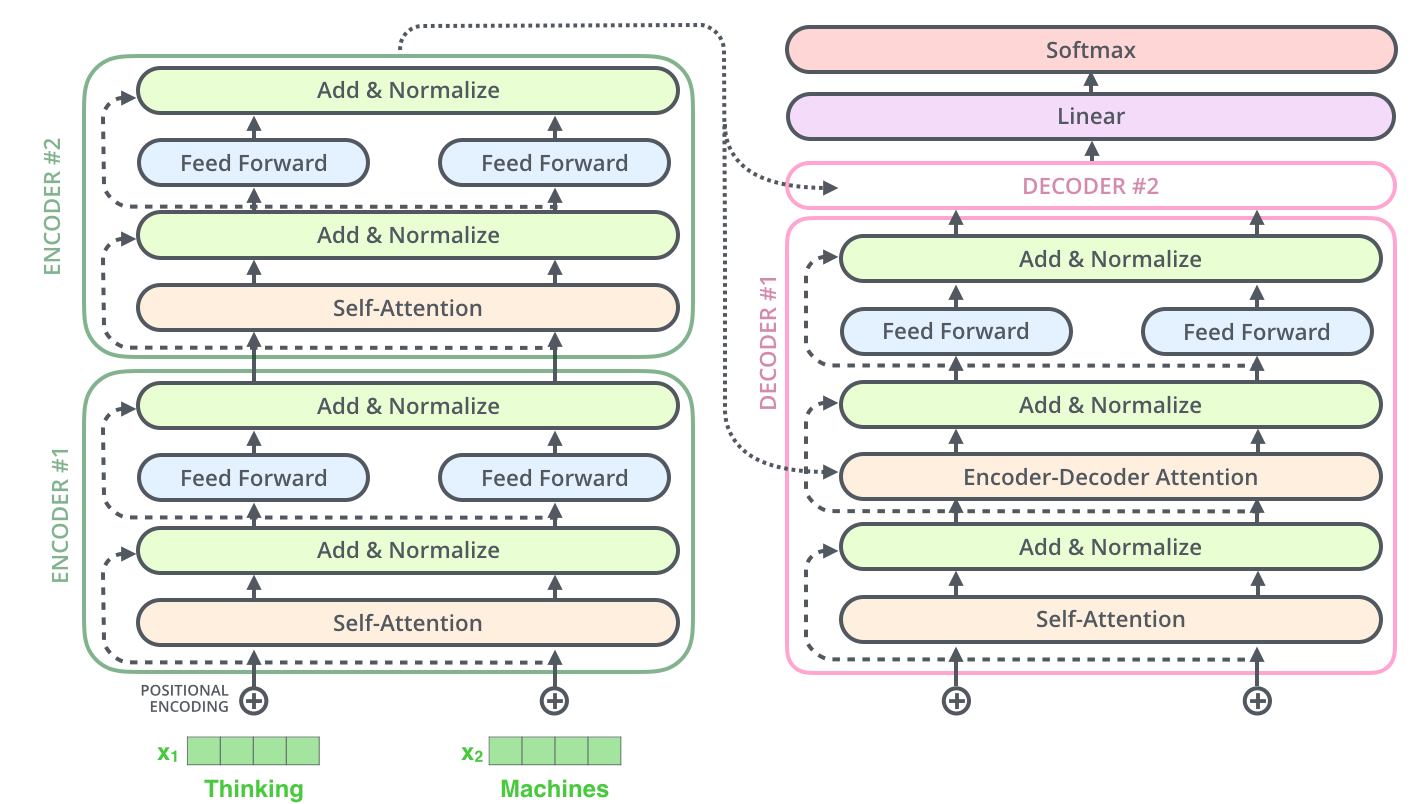

## Train

In [31]:
criterion = nn.CrossEntropyLoss(reduction='mean')
# 한 배치에 대한 평균이 계산됩니다. 
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    count = 0
    for batch in train_iter : 
        count += 1
        if count % 50 == 0 : 
            print("{}번째 에포크, {}번째 배치가 진행중입니다.".format(epoch,count))
        src_ = batch.src
        trg_ = batch.trg
        
        optimizer.zero_grad()
        
        outputs = model(src_, trg_)
        
        outputs = outputs[:,1:].contiguous().view(-1,outputs.size(-1))
        loss_trg = trg_.permute(1,0)[:,1:].contiguous().view(-1)
        
        loss = criterion(outputs, loss_trg)
        loss.backward()
        optimizer.step()
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

0번째 에포크, 50번째 배치가 진행중입니다.
0번째 에포크, 100번째 배치가 진행중입니다.
0번째 에포크, 150번째 배치가 진행중입니다.
0번째 에포크, 200번째 배치가 진행중입니다.
0번째 에포크, 250번째 배치가 진행중입니다.
0번째 에포크, 300번째 배치가 진행중입니다.
0번째 에포크, 350번째 배치가 진행중입니다.
0번째 에포크, 400번째 배치가 진행중입니다.
0번째 에포크, 450번째 배치가 진행중입니다.
0번째 에포크, 500번째 배치가 진행중입니다.
0번째 에포크, 550번째 배치가 진행중입니다.
Epoch: 0001 cost = 0.002039
1번째 에포크, 50번째 배치가 진행중입니다.
1번째 에포크, 100번째 배치가 진행중입니다.
1번째 에포크, 150번째 배치가 진행중입니다.
1번째 에포크, 200번째 배치가 진행중입니다.
1번째 에포크, 250번째 배치가 진행중입니다.
1번째 에포크, 300번째 배치가 진행중입니다.
1번째 에포크, 350번째 배치가 진행중입니다.
1번째 에포크, 400번째 배치가 진행중입니다.
1번째 에포크, 450번째 배치가 진행중입니다.
1번째 에포크, 500번째 배치가 진행중입니다.
1번째 에포크, 550번째 배치가 진행중입니다.
Epoch: 0002 cost = 0.000307
2번째 에포크, 50번째 배치가 진행중입니다.
2번째 에포크, 100번째 배치가 진행중입니다.
2번째 에포크, 150번째 배치가 진행중입니다.
2번째 에포크, 200번째 배치가 진행중입니다.
2번째 에포크, 250번째 배치가 진행중입니다.
2번째 에포크, 300번째 배치가 진행중입니다.
2번째 에포크, 350번째 배치가 진행중입니다.
2번째 에포크, 400번째 배치가 진행중입니다.
2번째 에포크, 450번째 배치가 진행중입니다.
2번째 에포크, 500번째 배치가 진행중입니다.
2번째 에포크, 550번째 배치가 진행중입니다.
Epoch: 0003 cost = 0.000182
3번째 에포크, 50번째 배치가 진행중입니다.
3번

KeyboardInterrupt: 

In [32]:
def show_src_trg_sent(batch_train,src=True) : 
    if src : 
        return ','.join([src_idx_to_word[i.item()] for i in batch_train \
        if i.item() != 0 and i.item() != 1 and i.item() != 2 and i.item() != 3]).replace(",",' ')
    else : 
        return ','.join([trg_idx_to_word[i.item()] for i in batch_train \
        if i.item() != 0 and i.item() != 1 and i.item() != 2 and i.item() != 3]).replace(",",' ')

In [33]:
src_batch_train = batch.src.transpose(1,0)[0]
trg_batch_train = batch.trg.transpose(1,0)[0]

In [34]:
print(show_src_trg_sent(src_batch_train))
print(show_src_trg_sent(trg_batch_train,src=False))

. hinauf sandhügel einen auf himmel bewölktem bei person anderen einer hilft person eine
one person helping another person up to the top of a mound of sand underneath a cloudy sky .


In [36]:
predict = model(batch.src,batch.trg)

In [37]:
predict = predict[0,:].data.max(1,keepdim=True)[1]
predict.size()

torch.Size([29, 1])

In [38]:
','.join([trg_idx_to_word[i.item()] for i in predict if i.item() != 0 and i.item() != 1 and i.item() != 2 and i.item() != 3]).replace(",",' ')

'with one person helping another person up to the top of a mound of sand underneath a cloudy sky .'